# Simultaneous vs Separate vs White_Light Fitting

With `chromatic_fitting` there are 3 different types of fit available: **Simultaneous**, **Separate** and **White_Light**. Respectively, they mean fitting all wavelengths simultaneously (possibility for shared parameters), fitting each wavelength independantly (no shared parameters) and averaging over all wavelengths to generate a white-light curve and fitting that. In this tutorial we will demonstrate all three methods and see the differences between them. `chromatic_fitting` is designed so that the interface should be the same regardless of the method chosen!

We will return to the transit model tutorial (in a speedy way, so if you haven't already done this tutorial or are unfamiliar with `chromatic_fitting` I recommend going through this now):

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.3!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.3.14
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

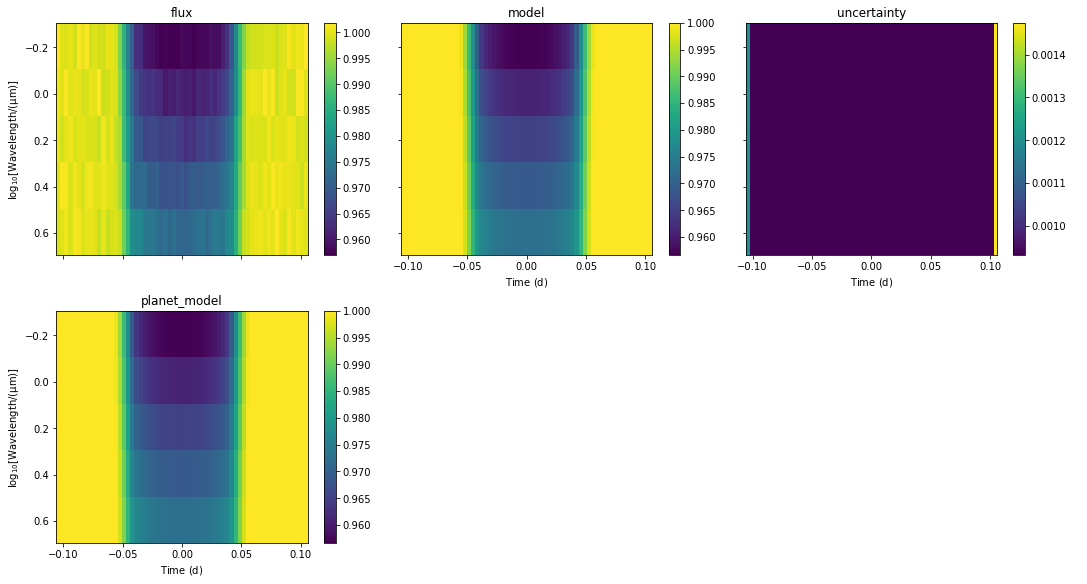

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

# bin into 5 wavelength bins:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

# show the simulated dataset
rbin5.imshow_quantities();

In [3]:
# create transit model:
t = TransitModel()

# add our parameters:
t.setup_parameters(
                  period=1, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 1.5707963267948966 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(testval=[0.05, 0.35], name='transit_limb_darkening') for each wavelength 🧮>



In [4]:
# attach the Rainbow object to the model:
t.attach_data(rbin5)

Now this is where we have to make the decision of which optimization method to use. By default the optimization is simultaneous:

In [5]:
t.choose_optimization_method()

In [6]:
t.optimization

'simultaneous'

However, we can change this to one of the other two if we like

In [7]:
t.choose_optimization_method("separate")
t.optimization

'separate'

The optimization method (if you want to change it) needs to be defined before we call `.setup_lightcurves()`.

In [8]:
# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

If we look at our `PyMC3` model, if we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [9]:
t._pymc3_model

We use a list of models rather than one model to avoid overwriting parameters for different wavelengths in the same model. We can look at the individual models:

In [10]:
t._pymc3_model[0]

In [11]:
t._pymc3_model[2]

Now we can change to another type of optimization method. **BEWARE!** In changing from simultaneous to separate methods we have changed our parameters to all be "WavelikeFitted" or "WavelikeFixed" therefore they won't have memory of their parameter class (Fitted or Fixed) before this! This doesn't matter for the white_light optimization but it will if you want to go back to simultaneous. In this case you need to go back and `.setup_parameters()` again! 

In [15]:
# If we want to change the optimization method then we need to reinitialize all the models/priors!
t.reinitialize()

# change the optimization method to white_light:
t.choose_optimization_method("white_light")
t.optimization

# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

Cleared transit_stellar_radius prior
Cleared transit_stellar_mass prior
Cleared transit_radius_ratio prior
Cleared transit_epoch prior
Cleared transit_baseline prior
Cleared transit_impact_parameter prior
Cleared transit_limb_darkening prior


  0%|          | 0/1 [00:00<?, ?it/s]

Now let's have another look at our PyMC3 model:

In [16]:
t._pymc3_model

We should only have one wavelength - a white-lightcurve that we can access using `.white_light`:

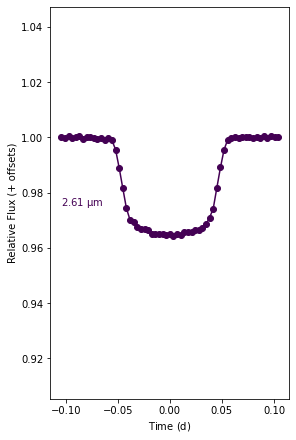

In [17]:
t.white_light.plot_lightcurves();